# Setup

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import skew

# Data Preparation 
Read scraped data

In [2]:
df =  pd.read_csv('Data_Boliga_20220208.csv')

df.head()

,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms_YearBuilt_PriceChange
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5.000.000 kr.,17-01-2022,Alm. Salg,93 m²,53.763 kr/m²,3 2007 -5% Aktuel værdi
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8.495.000 kr.,14-01-2022,Alm. Salg,170 m²,49.971 kr/m²,6 1929 Aktuel værdi
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5.400.000 kr.,14-01-2022,Alm. Salg,105 m²,51.429 kr/m²,3 1863 -2% Aktuel værdi
3,E,"Badensgade 48, 2",2300 København S,7.200.000 kr.,14-01-2022,Alm. Salg,65 m²,110.769 kr/m²,3 1899 Aktuel værdi
4,E,"Badensgade 48, 1",2300 København S,7.200.000 kr.,14-01-2022,Alm. Salg,79 m²,91.139 kr/m²,3 1899 Aktuel værdi


## Initial filter

Keep only observations for apartments which was soled as "almindelig salg".

In [3]:
print(df.shape)

df = df[(df['Type'] == 'E') & (df['SellType'] == 'Alm. Salg')]

print(df.shape)

(54793, 9)
(40673, 9)


## Transform data

### Text to numeric

In [4]:
df['Price'] = df['Price'].str.replace('.', '', regex = True).str.replace('kr', '', regex = True)
df['Size'] = df['Size'].str.extract('(\d+)')
df['Price_m2']  = df['Price_m2'].str.replace('.', '', regex = True).str.extract('(\d+)')
df[['Rooms', 'YearBuilt', 'PriceChange']] =  df['Rooms_YearBuilt_PriceChange'].str.split(' ', expand = True).iloc[:,0:3]
df.loc[df['PriceChange'] == 'Aktuel', ['PriceChange']] = '0'
df['PriceChange'] = df['PriceChange'].str.replace('%', '', regex  =True)

df['PostalCode'] = df['Area'].str.extract('(\d{4})')
df['AreaName'] = df['Area'].str.extract('(\D+)')

# Check first rows
df.head()


,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms_YearBuilt_PriceChange,Rooms,YearBuilt,PriceChange,PostalCode,AreaName
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5000000,17-01-2022,Alm. Salg,93,53763,3 2007 -5% Aktuel værdi,3,2007,-5,2100,København Ø
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8495000,14-01-2022,Alm. Salg,170,49971,6 1929 Aktuel værdi,6,1929,0,2100,København Ø
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5400000,14-01-2022,Alm. Salg,105,51429,3 1863 -2% Aktuel værdi,3,1863,-2,2200,København N
3,E,"Badensgade 48, 2",2300 København S,7200000,14-01-2022,Alm. Salg,65,110769,3 1899 Aktuel værdi,3,1899,0,2300,København S
4,E,"Badensgade 48, 1",2300 København S,7200000,14-01-2022,Alm. Salg,79,91139,3 1899 Aktuel værdi,3,1899,0,2300,København S


Lets check that the price per m2 is correctly calculated.

Convert from characters to numeric. Note the change for a row where an incorrect value had been registered for price change.

In [5]:
# Correct value
df.loc[df['PriceChange'] == '299.499.900', 'PriceChange'] = 0 

# Creat list with columns to convert
num_cols = ['Price', 'Size', 'Price_m2', 'Rooms', 'YearBuilt', 'PriceChange', 'PostalCode']

# Loop over list
for col in num_cols:
    
    df[col] = df[col].astype(int)
    
# Check data types
print(df.dtypes)

Type                           object
StreetAddress                  object
Area                           object
Price                           int32
Date                           object
SellType                       object
Size                            int32
Price_m2                        int32
Rooms_YearBuilt_PriceChange    object
Rooms                           int32
YearBuilt                       int32
PriceChange                     int32
PostalCode                      int32
AreaName                       object
dtype: object


### Floor number

Create variable for the floor number of the apartment by extracting the number from street address column, "st" stands for ground floor.

In [6]:
df['Floor'] = df['StreetAddress'].str.extract(', (\d+|st)')
df.loc[df['Floor'] == 'st', 'Floor'] = 0

Check if any null values appeared for the floor number.

In [7]:
df_floor_null = df[df['Floor'].isnull()]

print(df_floor_null.shape)

df_floor_null.head(15)

(433, 15)


,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms_YearBuilt_PriceChange,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Floor
48,E,Overbys Allé 1A,2500 Valby,7550000,05-01-2022,Alm. Salg,121,62397,6 1900 -6% Aktuel værdi,6,1900,-6,2500,Valby,NaN
398,E,Strandgade 10A,1401 København K,11200000,01-12-2021,Alm. Salg,216,51852,5 1720 Aktuel værdi,5,1720,0,1401,København K,NaN
647,E,Øresundsvej 132D,2300 København S,6995000,13-11-2021,Alm. Salg,132,52992,4 1934 Aktuel værdi,4,1934,0,2300,København S,NaN
724,E,Norgesmindevej 35,2900 Hellerup,11350000,10-11-2021,Alm. Salg,223,50897,5 1908 Aktuel værdi,5,1908,0,2900,Hellerup,NaN
777,E,Kirkebjerg Allé 38,2720 Vanløse,2555000,07-11-2021,Alm. Salg,59,43305,2 1903 -2% Aktuel værdi,2,1903,-2,2720,Vanløse,NaN
862,E,Øresundsvej 132C,2300 København S,5995000,02-11-2021,Alm. Salg,132,45417,4 1934 Aktuel værdi,4,1934,0,2300,København S,NaN
992,E,Prøvestens Allé 3A,2300 København S,2870000,27-10-2021,Alm. Salg,74,38784,2 1900 -4% Aktuel værdi,2,1900,-4,2300,København S,NaN
1586,E,Rosenvængets Allé 5A,2100 København Ø,3750000,28-09-2021,Alm. Salg,59,63559,2 1875 Aktuel værdi,2,1875,0,2100,København Ø,NaN
1812,E,Øresundsvej 126A,2300 København S,2895000,21-09-2021,Alm. Salg,54,53611,2 1920 -3% Aktuel værdi,2,1920,-3,2300,København S,NaN
1865,E,Constantin Hansens Gade 8C,1799 København V,3120000,19-09-2021,Alm. Salg,42,74286,1 2019 -2% Aktuel værdi,1,2019,-2,1799,København V,NaN


There are 433 observations where a floor number can not be extracted. A quick check on some of the addresses shows that the type column is either coded incorrectly or the observations is an apartment located in a villa. Keep the obersvations for now, setting the floor variable to -1 for easy identification later.

In [8]:
df.loc[df['Floor'].isnull(), 'Floor'] = -1

df['Floor'] = df['Floor'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40673 entries, 0 to 54792
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Type                         40673 non-null  object
 1   StreetAddress                40673 non-null  object
 2   Area                         40673 non-null  object
 3   Price                        40673 non-null  int32 
 4   Date                         40673 non-null  object
 5   SellType                     40673 non-null  object
 6   Size                         40673 non-null  int32 
 7   Price_m2                     40673 non-null  int32 
 8   Rooms_YearBuilt_PriceChange  40673 non-null  object
 9   Rooms                        40673 non-null  int32 
 10  YearBuilt                    40673 non-null  int32 
 11  PriceChange                  40673 non-null  int32 
 12  PostalCode                   40673 non-null  int32 
 13  AreaName                     40

## Select relevant columns

Drop redundant columns

In [9]:
df.drop(['Rooms_YearBuilt_PriceChange', 'Type', 'SellType', 'Area'], inplace = True, axis = 1)

# Filter data
The data need to be filtered for outliers and possible incorrect values. By checking summary statistics it is possible to spot a a couple if things.
- There are a large spread in values for price, size and price per sqm.
<br>
<br>
- The minimum value for YearBuilt is year 0, which seems odd.
<br>
<br>
- A price change o -100% or +249% does not seem realistic.


In [10]:
df.describe()

,Price,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,Floor
count,4.067300e+04,40673.000000,4.067300e+04,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000
mean,6.110597e+06,84.081528,8.375171e+04,2.828879,1909.852212,-1.215696,2201.134463,2.179136
std,8.870159e+06,36.692984,1.798071e+05,1.142108,247.538151,4.237192,379.485450,1.933333
min,5.119900e+04,12.000000,4.570000e+02,1.000000,0.000000,-99.000000,1050.000000,-1.000000
25%,2.225000e+06,58.000000,3.423900e+04,2.000000,1904.000000,-2.000000,2100.000000,1.000000
50%,3.400000e+06,76.000000,4.210500e+04,3.000000,1935.000000,0.000000,2300.000000,2.000000
75%,5.275000e+06,102.000000,5.253600e+04,3.000000,1975.000000,0.000000,2450.000000,3.000000
max,8.500000e+07,857.000000,4.083333e+06,13.000000,2021.000000,249.000000,2900.000000,29.000000


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Price_m2'}>],
       [<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'PriceChange'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>,
        <AxesSubplot:title={'center':'Floor'}>, <AxesSubplot:>]],
      dtype=object)

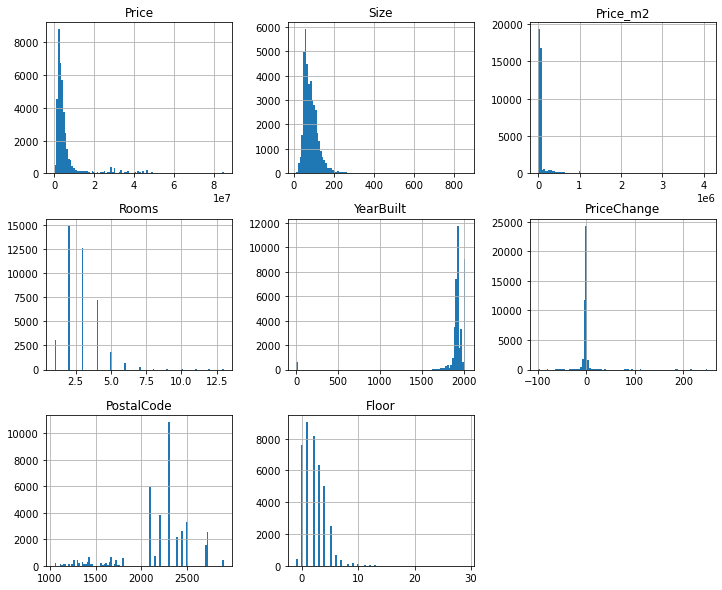

In [11]:
df.hist(bins=100, figsize=(12,10))

Check some boxplots to identify possible outliers

<AxesSubplot:>

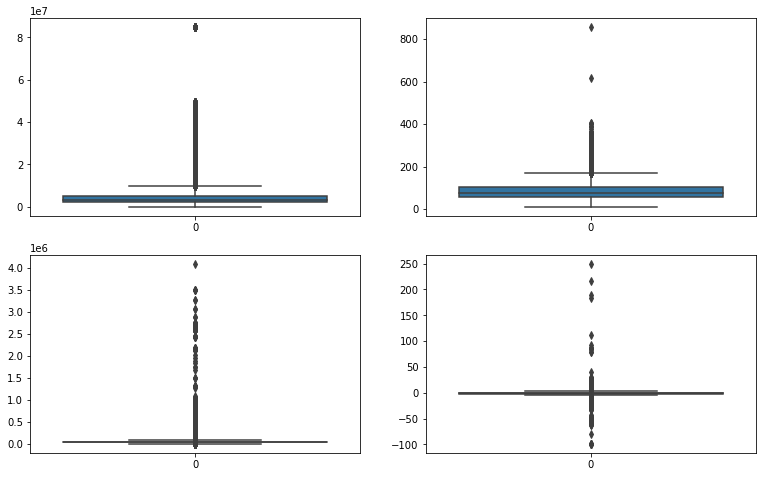

In [12]:
fig = plt.figure(figsize = (13,8))


plt.subplot(2,2,1)
sns.boxplot(data = df['Price'])
plt.subplot(2,2,2)
sns.boxplot(data = df['Size'])
plt.subplot(2,2,3)
sns.boxplot(data= df['Price_m2'])
plt.subplot(2,2,4)
sns.boxplot(data = df['PriceChange'])

### Price vs size

There seems to be quite some spread in the variables as well as some outliers, for example a maximum price of 85,000,000 DKK or a maximum size of 857 square meters. Let's to plot the relationship between price and size.

<AxesSubplot:xlabel='Size', ylabel='Price'>

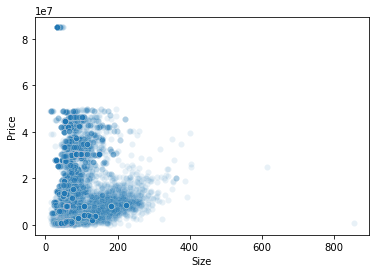

In [13]:
sns.scatterplot(data = df,
            x = 'Size',
            y = 'Price',
            alpha = 0.1)

There seems to be several apartments that have been sold for 85 million, which seems a bit odd. Let's look more into those observations.

In [14]:
df.loc[df['Price'] > 80000000].head(10)

,StreetAddress,Price,Date,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Floor
42052,"Store Kongensgade 100, 5. 13",85000000,16-01-2017,31,2741936,1,1970,0,1264,København K,5
42053,"Store Kongensgade 100, 3. 4",85000000,16-01-2017,39,2179487,1,1970,0,1264,København K,3
42054,"Store Kongensgade 100, 5. 8",85000000,16-01-2017,32,2656250,1,1970,0,1264,København K,5
42055,"Store Kongensgade 100, 3. 5",85000000,16-01-2017,33,2575758,1,1970,0,1264,København K,3
42056,"Store Kongensgade 100, 2. 2",85000000,16-01-2017,32,2656250,1,1970,0,1264,København K,2
42057,"Store Kongensgade 100, 3. 1",85000000,16-01-2017,31,2741936,1,1970,0,1264,København K,3
42058,"Store Kongensgade 100, 2. 8",85000000,16-01-2017,32,2656250,1,1970,0,1264,København K,2
42059,"Store Kongensgade 100, 6. 3",85000000,16-01-2017,49,1734694,2,1970,0,1264,København K,6
42060,"Store Kongensgade 100, 3. 2",85000000,16-01-2017,32,2656250,1,1970,0,1264,København K,3
42061,"Store Kongensgade 100, 2. 13",85000000,16-01-2017,31,2741936,1,1970,0,1264,København K,2


It seems like these are apartments bought in larger housing investments, which is probably the case for the other data points showing similar horizontal lines in the plot. By counting number of observations by street address (excluding floor and apartment), price, and date, I can find similar instances, which most probably are not private acqusitions.

In [15]:
# Extract street address
df['Street'] =  df['StreetAddress'].str.extract("([^0-9]+\d{0,3})")

# Create data frame with number of obersvations for each price, date and street
df_mult_out = (df.groupby(['Price', 'Date', 'Street'])['Price'].size()
               .sort_values(ascending = False)
               .reset_index(name = 'Count')
               .query('Count >= 2')
              )

df_mult_out.head(10)

,Price,Date,Street,Count
0,28101990,14-08-2018,Amagerfælledvej 62,337
1,8350000,02-01-2015,Esromgade 26,184
2,85000000,16-01-2017,Store Kongensgade 100,72
3,46496250,03-11-2015,Richard Mortensens Vej 78,67
4,30500000,07-01-2015,Lergravsvej 36,57
5,3995000,06-03-2018,Husumgade 12,38
6,25500000,01-10-2015,Strandlodsvej 5,37
7,30500000,07-01-2015,Lergravsvej 32,35
8,30500000,07-01-2015,Lergravsvej 34,35
9,21600000,27-02-2020,Artillerivej 159,35


There are many these cases, lets filter out the observations being part of these investments and check how many observations that are filtered out. 

In [16]:
print(df_mult_out['Count'].sum())

# Join number of counts to original data frame nad filter out rows 
df = (
    df.merge(
    df_mult_out,
    how = 'left',
    on = ['Price', 'Date', 'Street'])
    .query('Count.isna()', engine = 'python')
)

print(df.shape)
df.head()

df.drop('Count', axis = 1, inplace = True)

7352
(33321, 13)


Plot the price vs. size to see how the filtering has changed the data.

<AxesSubplot:xlabel='Size', ylabel='Price'>

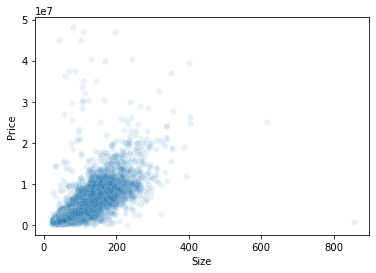

In [17]:
sns.scatterplot(data = df,
            x = 'Size',
            y = 'Price',
            alpha = 0.1)

### Outliers
The plot above still indicates some outliers in the data which demands some attention. Before heading on, lets check that the given price per m2 is correct.




In [26]:
# Calculate price per m2
df['Price_m2_calc'] = round(df['Price'] / df['Size'],0).astype(int)
df['Price_m2_diff'] = df['Price_m2_calc'] - df['Price_m2']


# See if price per m2 is different for any observations
df[df['Price_m2_diff'] != 0].describe()

,Price,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,Floor,Price_m2_calc,Price_m2_diff
count,2.240000e+02,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,4.414761e+06,89.303571,40175.723214,3.348214,1890.571429,-1.709821,2072.017857,1.665179,46440.718750,6264.995536
std,3.400585e+06,43.267204,14538.180483,1.767722,229.934119,2.926712,442.952396,1.738367,21111.783999,11947.270400
min,3.750000e+05,32.000000,4688.000000,1.000000,0.000000,-14.000000,1051.000000,-1.000000,8523.000000,-1.000000
25%,2.175000e+06,64.000000,31531.750000,2.000000,1895.000000,-3.000000,1718.000000,0.000000,33499.500000,-1.000000
50%,3.232500e+06,80.000000,38881.000000,3.000000,1911.500000,-1.000000,2200.000000,1.000000,41562.000000,-1.000000
75%,5.762500e+06,112.000000,48063.000000,4.000000,1939.000000,0.000000,2300.000000,3.000000,53366.250000,8230.000000
max,1.770000e+07,259.000000,107813.000000,9.000000,2020.000000,8.000000,2900.000000,6.000000,134643.000000,64828.000000


There are 224 where the price per m2 is not equal to what has been calculated, in some cases the difference is probably due to rounding procedures. For larger differences one of the three variables size, price, or price per m2 is incorrect. It is notable that the minimum differnce is -1, indicating that the incorrect values either are either given by too high selling price or a too small size.

Check what the distribution of the values looks like for differences below 100.

<AxesSubplot:>

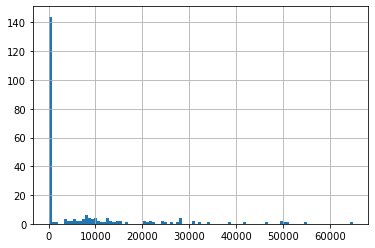

In [48]:
df[(df['Price_m2_diff'] != 0) ]['Price_m2_diff'].hist(bins = 100)

The differences between the calculated price per m2 and what has been registered seems quite large for some observations. To minimize the risk of using incorrect data, the observations with a difference larger than 1 will be discarded, since it indicates that some of the data is incorrect, even though it might only be the calculation of price per m2, and not the actual price or size.

In [51]:
df = df[abs(df['Price_m2_diff'] <=1)].copy()

By again looking at the distribution and skewness of price per m2, we can get an idea for what limits to impose on our values.

15.831032201991464


<AxesSubplot:>

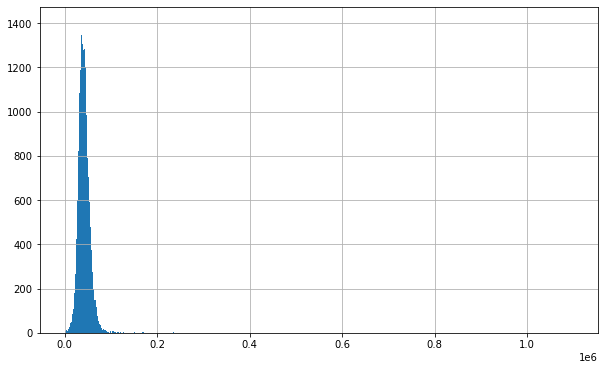

In [52]:
print(skew(df['Price_m2']))
df['Price_m2'].hist(bins=1000, figsize=(10,6))

Both the histogram and the sample skewness indicates a relatively skewed distribution, hence, I will use the method of filtering outliers based on the interquartile range (IQR).

The formula for filtering is simple:

P_25 - 1.5IQR < x < P_75 + 1.5IQR

IQR = P_75 - P_25

In [53]:
pm2_p25 = np.percentile(df['Price_m2'], 25)
pm2_p75 = np.percentile(df['Price_m2'], 75)
pm2_IQR = pm2_p75 - pm2_p25

pm2_low = pm2_p25 - 1.5*pm2_IQR
pm2_high= pm2_p75 + 1.5*pm2_IQR

print("25th percentile: ", pm2_p25)
print("75th percentile: ",pm2_p75)
print("IQR: ",pm2_IQR)
print("Lowest value for price_m2: ", pm2_low)
print("Highest value for price_m2: ", pm2_high)


25th percentile:  33544.0
75th percentile:  48214.0
IQR:  14670.0
Lowest value for price_m2:  11539.0
Highest value for price_m2:  70219.0


Filter values 

In [54]:
df = df[(df['Price_m2'] >=pm2_low) & (df['Price_m2'] <= pm2_high)].copy()

df.shape

(32488, 14)

<AxesSubplot:>

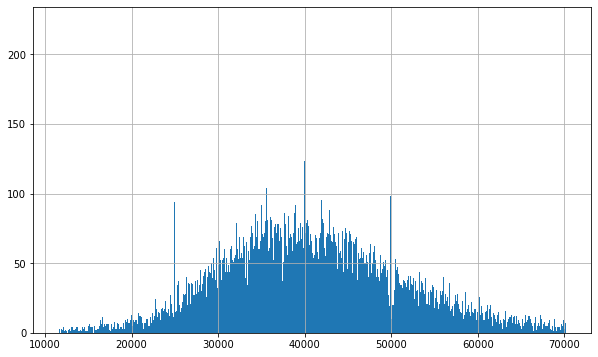

In [55]:
df['Price_m2'].hist(bins=1000, figsize=(10,6))

<AxesSubplot:xlabel='Size', ylabel='Price'>

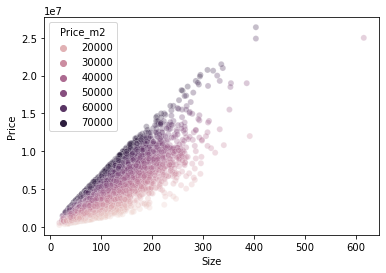

In [56]:
sns.scatterplot(data = df,
                x = 'Size',
                y = 'Price',
                alpha = 0.3,
                hue = 'Price_m2'
               )

In [57]:
df.describe()

,Price,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,Floor,Price_m2_calc,Price_m2_diff
count,3.248800e+04,32488.000000,32488.000000,32488.000000,32488.000000,32488.000000,32488.000000,32488.000000,32488.000000,32488.000000
mean,3.466047e+06,82.965310,40900.962355,2.764929,1924.548603,-1.419724,2195.942410,2.248707,40900.958046,-0.004309
std,1.924422e+06,35.182526,10506.177320,1.061790,201.149227,3.353982,370.731844,1.931161,10506.177806,0.065505
min,2.450000e+05,18.000000,11584.000000,1.000000,0.000000,-80.000000,1051.000000,-1.000000,11584.000000,-1.000000
25%,2.100000e+06,57.000000,33494.250000,2.000000,1908.000000,-3.000000,2100.000000,1.000000,33494.250000,0.000000
50%,2.995000e+06,74.000000,40268.000000,3.000000,1936.000000,0.000000,2300.000000,2.000000,40268.000000,0.000000
75%,4.340000e+06,100.000000,47768.000000,3.000000,1989.000000,0.000000,2400.000000,3.000000,47768.000000,0.000000
max,2.640000e+07,616.000000,70175.000000,12.000000,2021.000000,93.000000,2900.000000,26.000000,70175.000000,0.000000


In [ ]:
fig = plt.figure(figsize = (13,8))


plt.subplot(2,2,1)
sns.boxplot(data = df['Price'])
plt.subplot(2,2,2)
sns.boxplot(data = df['Size'])
plt.subplot(2,2,3)
sns.boxplot(data= df['Price_m2'])
plt.subplot(2,2,4)
sns.boxplot(data = df['PriceChange'])


### Size

There still seem to be some outliers with regards to size. Start by visualizing the distribution of apartment sizes by a box plot and again the relationship between price and size.

In [ ]:
sns.boxplot(data = df['Size'])


df[['Size', 'Price_m2']].describe()

In [ ]:
sns.scatterplot(data = df,
                x = 'Size',
                y = 'Price',
                alpha = 0.3
               )

In [ ]:
df['Price_m2_norm'] = (df['Price_m2'] - df['Price_m2'].mean()) / df['Price_m2'].std()

print(df['Price_m2_norm'].describe())

sns.scatterplot(data = df,
                x = 'Size',
                y = 'Price',
                hue='Price_m2_norm', 
                palette='RdBu',
                #alpha = 0.3
               )




In [ ]:
px.scatter(df,
           x = 'Size',
           y = 'Price',
           color = 'Price_m2'
          )

In [ ]:
df['Price_m2_calc']  = round(df['Price'] / df['Size'],0)

df[df['Price_m2'] != df['Price_m2_calc']]

Check the most extreme cases

In [ ]:
df.sort_values(by = 'Price_m2_norm')

The two observations around 850 and 400 m2 looks like outliers 

In [ ]:
max_size = 200
df_ls = df[df['Size'] > max_size]


In [ ]:
df_ls.hist(bins = 50,
           figsize=(12,10))





Write data to new file

In [ ]:
df.to_csv('Data_Boliga_20220208_cleaned_20220313.csv', index  = False)